# A glance at the prices of two oil benchmarks: WTI and Brent

In [2]:
library(tidyverse)
library(magrittr)
library(data.table)
library(lubridate)
library(quantmod)
library(TTR)
library(scales)

In [4]:
# 1. download WTI and Brent prices data ----------------------------------------
lTickersDict <- list(wti = "HCL=F", brent = "BZ=F")
# 1.1. load data from Yahoo
quantmod::getSymbols.yahoo(
  Symbols = unlist(lTickersDict),
  from = as.Date("1991-01-01"),
  to = as.Date("2020-12-31"),
  periodicity = "daily",
  env = .GlobalEnv
)
# 1.2. prepare Brent time series
dtBrent <- data.table::as.data.table(`BZ=F`)
cColsBrent <- c("index", "BZ=F.Close")
dtBrent <- dtBrent[, ..cColsBrent]
data.table::setnames(x = dtBrent, old = "BZ=F.Close", new = "brent_close")
data.table::fwrite(x = dtBrent, file = "data/brent_yahoo_prices2.csv")
# 1.3. prepare WTI time series
dtWti <- data.table::as.data.table(`HCL=F`)
cColsWti <- c("index", "HCL=F.Close")
dtWti <- dtWti[, ..cColsWti]
data.table::setnames(x = dtWti, old = "HCL=F.Close", new = "wti_close")
data.table::fwrite(x = dtWti, file = "data/wti_yahoo_prices.csv2")
# 1.4. join the prices
dtOil <- data.table::merge.data.table(
  x = dtBrent, y = dtWti, by = "index", all.x = F, all.y = F)
View(head(dtOil))

Warning message:
“HCL=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“BZ=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”


[1] "HCL=F" "BZ=F"

index,brent_close,wti_close
<date>,<dbl>,<dbl>
2018-11-05,73.17,69.62
2018-11-06,72.13,68.63
2018-11-07,72.07,68.20
2018-11-08,70.65,67.32
2018-11-09,70.18,66.82
2018-11-12,70.12,66.49


In [5]:
# 2. small technical analysis of Brent prices ----------------------------------
# 2.1. add 50D and 200D MAs
dtBrent[, brent_close := zoo::na.locf0(object = brent_close, fromLast = F)]
dtBrent[, brent_close_50d_ma := TTR::SMA(x = dtBrent$brent_close, n = 50)]
dtBrent[, brent_close_200d_ma := TTR::SMA(x = dtBrent$brent_close, n = 200)]
View(head(dtBrent))
# 2.2. melt the data into long format
dtMeltedBrent <- data.table::melt.data.table(
  data = dtBrent, id.vars = "index", measure.vars = colnames(dtBrent)[2:4], 
  variable.name = "which_price", value.name = "price")
View(head(dtMeltedBrent))

index,brent_close,brent_close_50d_ma,brent_close_200d_ma
<date>,<dbl>,<dbl>,<dbl>
2007-07-30,75.74,NA,NA
2007-07-31,77.05,NA,NA
2007-08-01,75.35,NA,NA
2007-08-02,75.76,NA,NA
2007-08-03,74.75,NA,NA
2007-08-06,71.17,NA,NA


index,which_price,price
<date>,<fct>,<dbl>
2007-07-30,brent_close,75.74
2007-07-31,brent_close,77.05
2007-08-01,brent_close,75.35
2007-08-02,brent_close,75.76
2007-08-03,brent_close,74.75
2007-08-06,brent_close,71.17


Warning message:
“Removed 248 row(s) containing missing values (geom_path).”


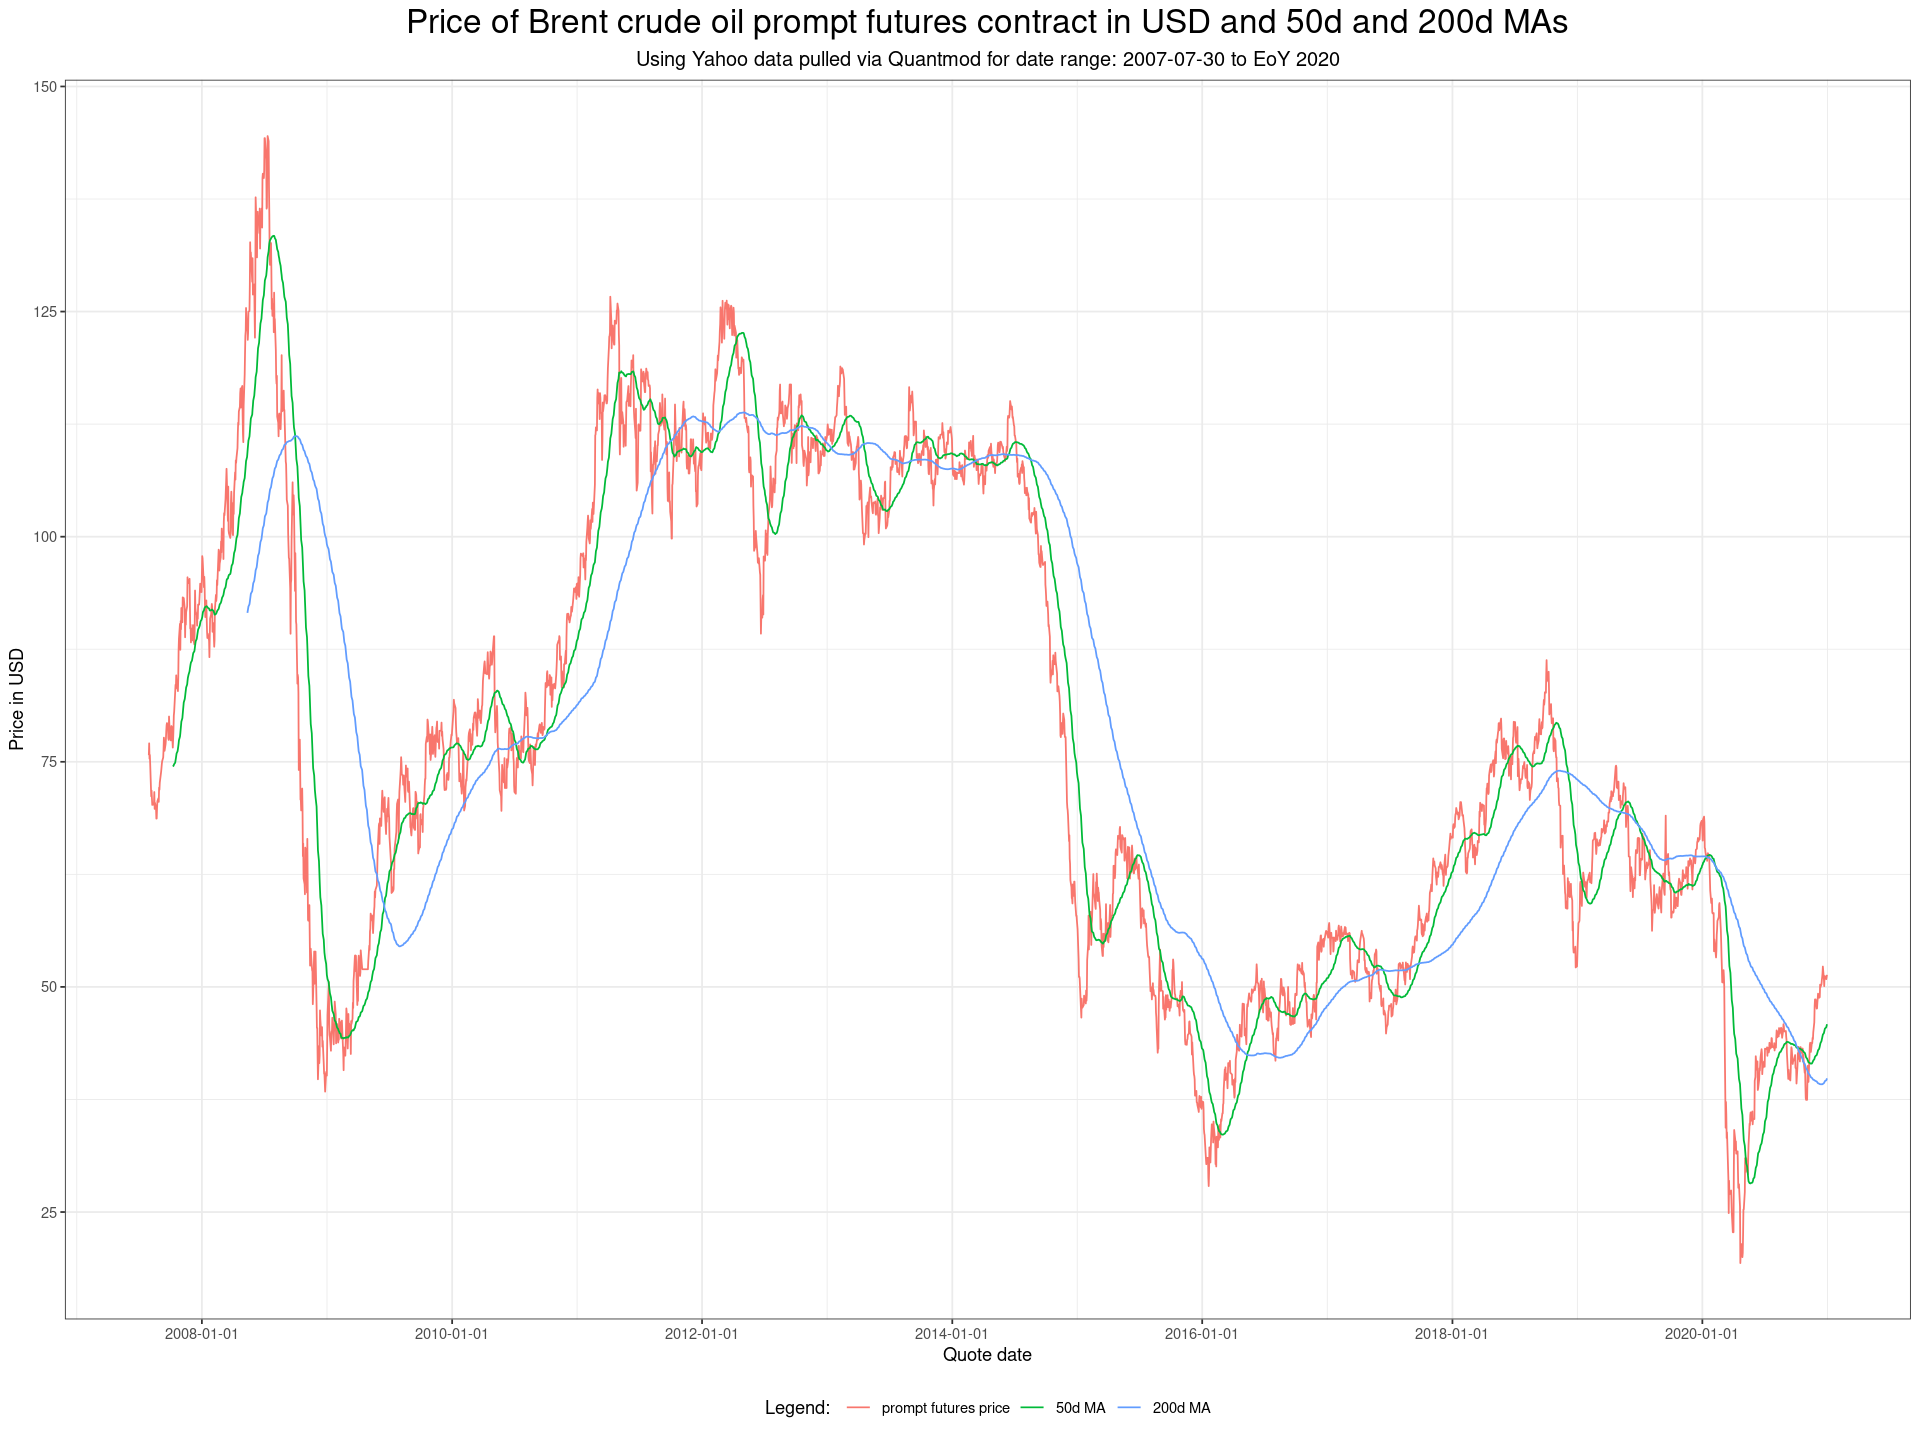

In [11]:
# 2.3. make a plot of Brent price and MAs
plotBrentPricesWithMAs <- 
  ggplot(data = dtMeltedBrent, mapping = aes(x = index, y = price, color = which_price)) +
  geom_line() + theme_bw() +
  xlab("Quote date") + ylab("Price in USD") +
  ggtitle(
    label = "Price of Brent crude oil prompt futures contract in USD and 50d and 200d MAs",
    subtitle = "Using Yahoo data pulled via Quantmod for date range: 2007-07-30 to EoY 2020"
  ) + 
  ggplot2::theme(legend.position = "bottom", 
                 plot.title = element_text(hjust = 0.5, size = 20),
                 plot.subtitle = element_text(hjust = 0.5, size = 12)) + 
  scale_color_discrete(
    name = "Legend: ",
    labels = c("prompt futures price", "50d MA", "200d MA")
  ) + scale_y_continuous(breaks = seq(0, 150, 25)) +
  scale_x_date(
    breaks = "2 year"
  )
options(repr.plot.width=16, repr.plot.height=12)
plotBrentPricesWithMAs

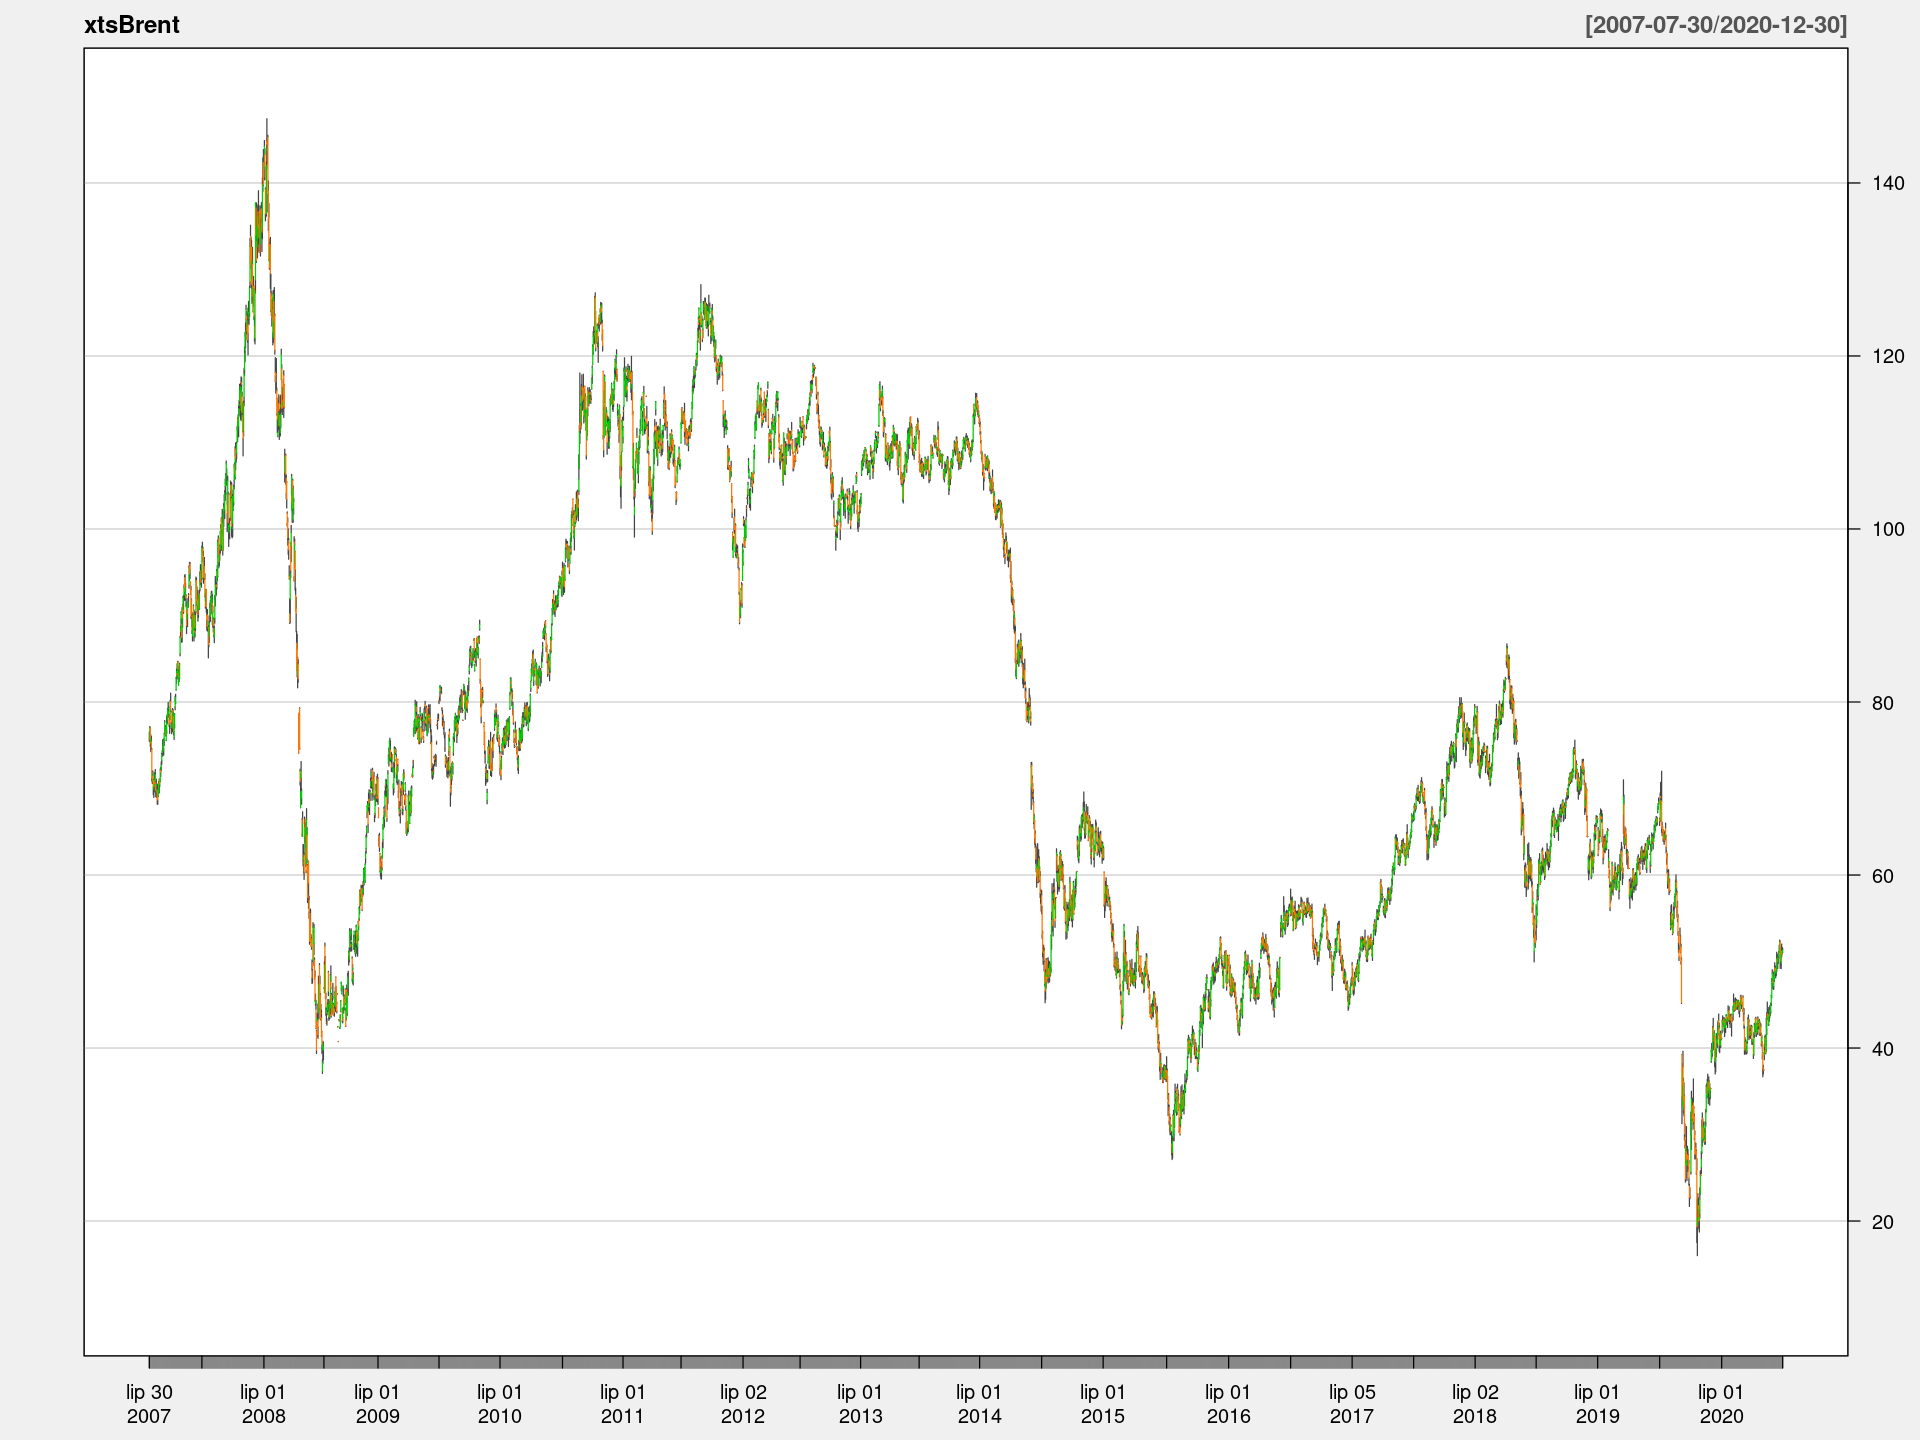

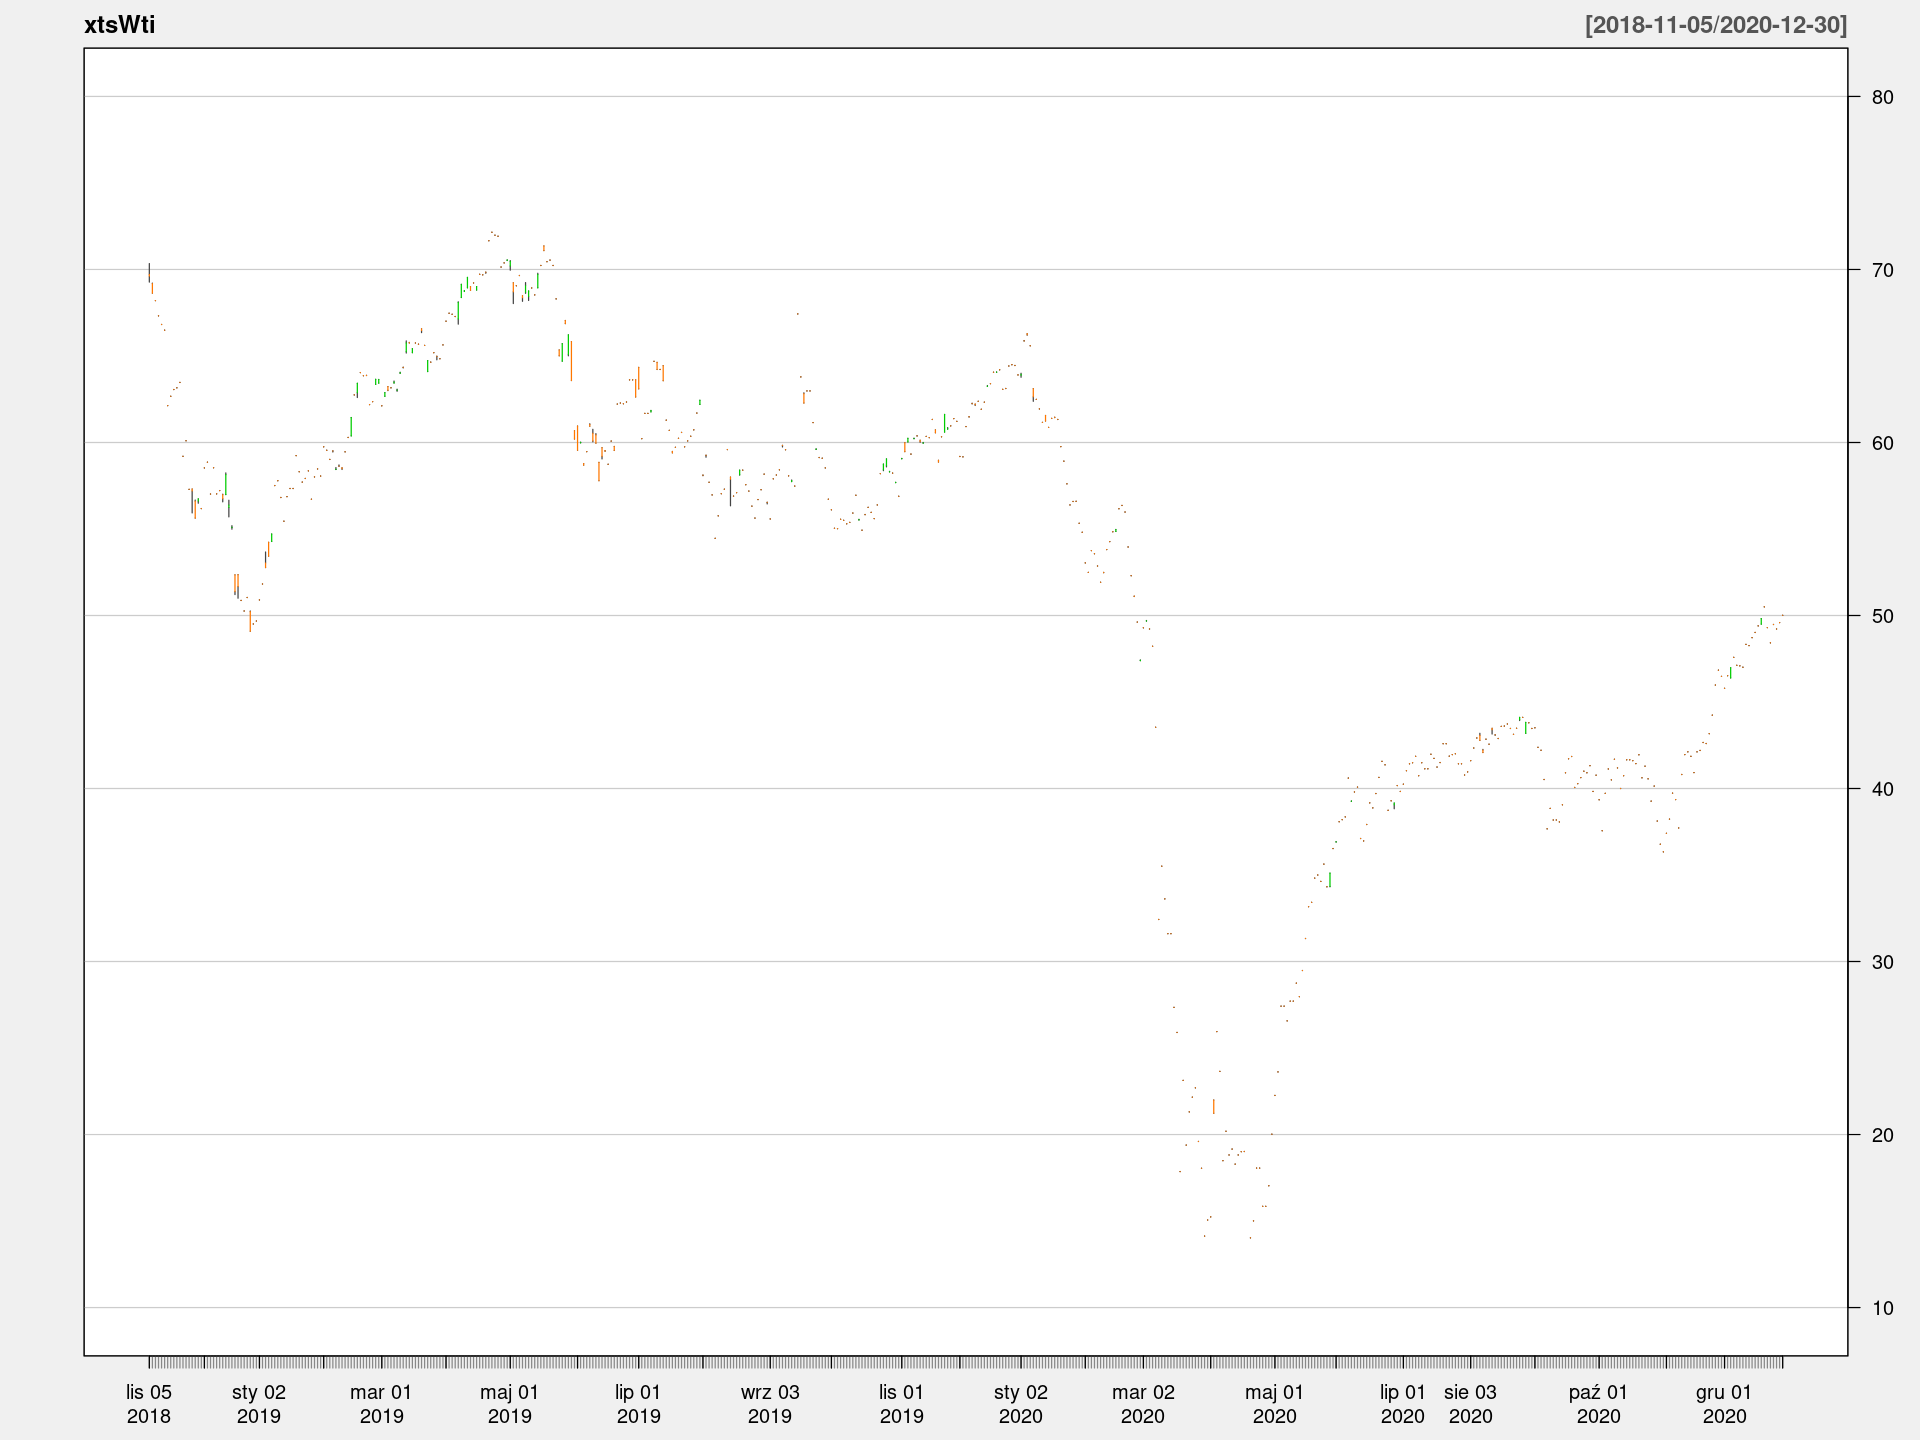

In [12]:
# 3. plotting qith quantmod ----------------------------------------------------
xtsBrent <- `BZ=F`
plotQuantmodBrent <- quantmod::chartSeries(
  x = xtsBrent, theme = quantmod::chartTheme("white"), TA = NULL, yrange = c(10, 150))
xtsWti <- `HCL=F`
plotQuantmodWti <- quantmod::chartSeries(
  x = xtsWti, theme = quantmod::chartTheme("white"), TA = NULL, yrange = c(10, 80))

In [13]:
# 4. statistical analysis of log-returns of both oil prices --------------------
# 4.1. keep only complete cases
dtOil <- dtOil[complete.cases(dtOil), ]
View(head(dtOil))
data.table::setnames(x = dtOil, old = c("brent_close", "wti_close"), new = c("brent", "wti"))
# 4.2. calculate log-returns and squared log-returns
dtOil[, `:=`(logret_brent = c(NA, diff(log(brent))), logret_wti = c(NA, diff(log(wti))))]
dtOil[, `:=`(sq_logret_brent = logret_brent^2, sq_logret_wti = logret_wti^2)]

index,brent_close,wti_close
<date>,<dbl>,<dbl>
2018-11-05,73.17,69.62
2018-11-06,72.13,68.63
2018-11-07,72.07,68.20
2018-11-08,70.65,67.32
2018-11-09,70.18,66.82
2018-11-12,70.12,66.49


Warning message in log(wti):
“NaNs produced”


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


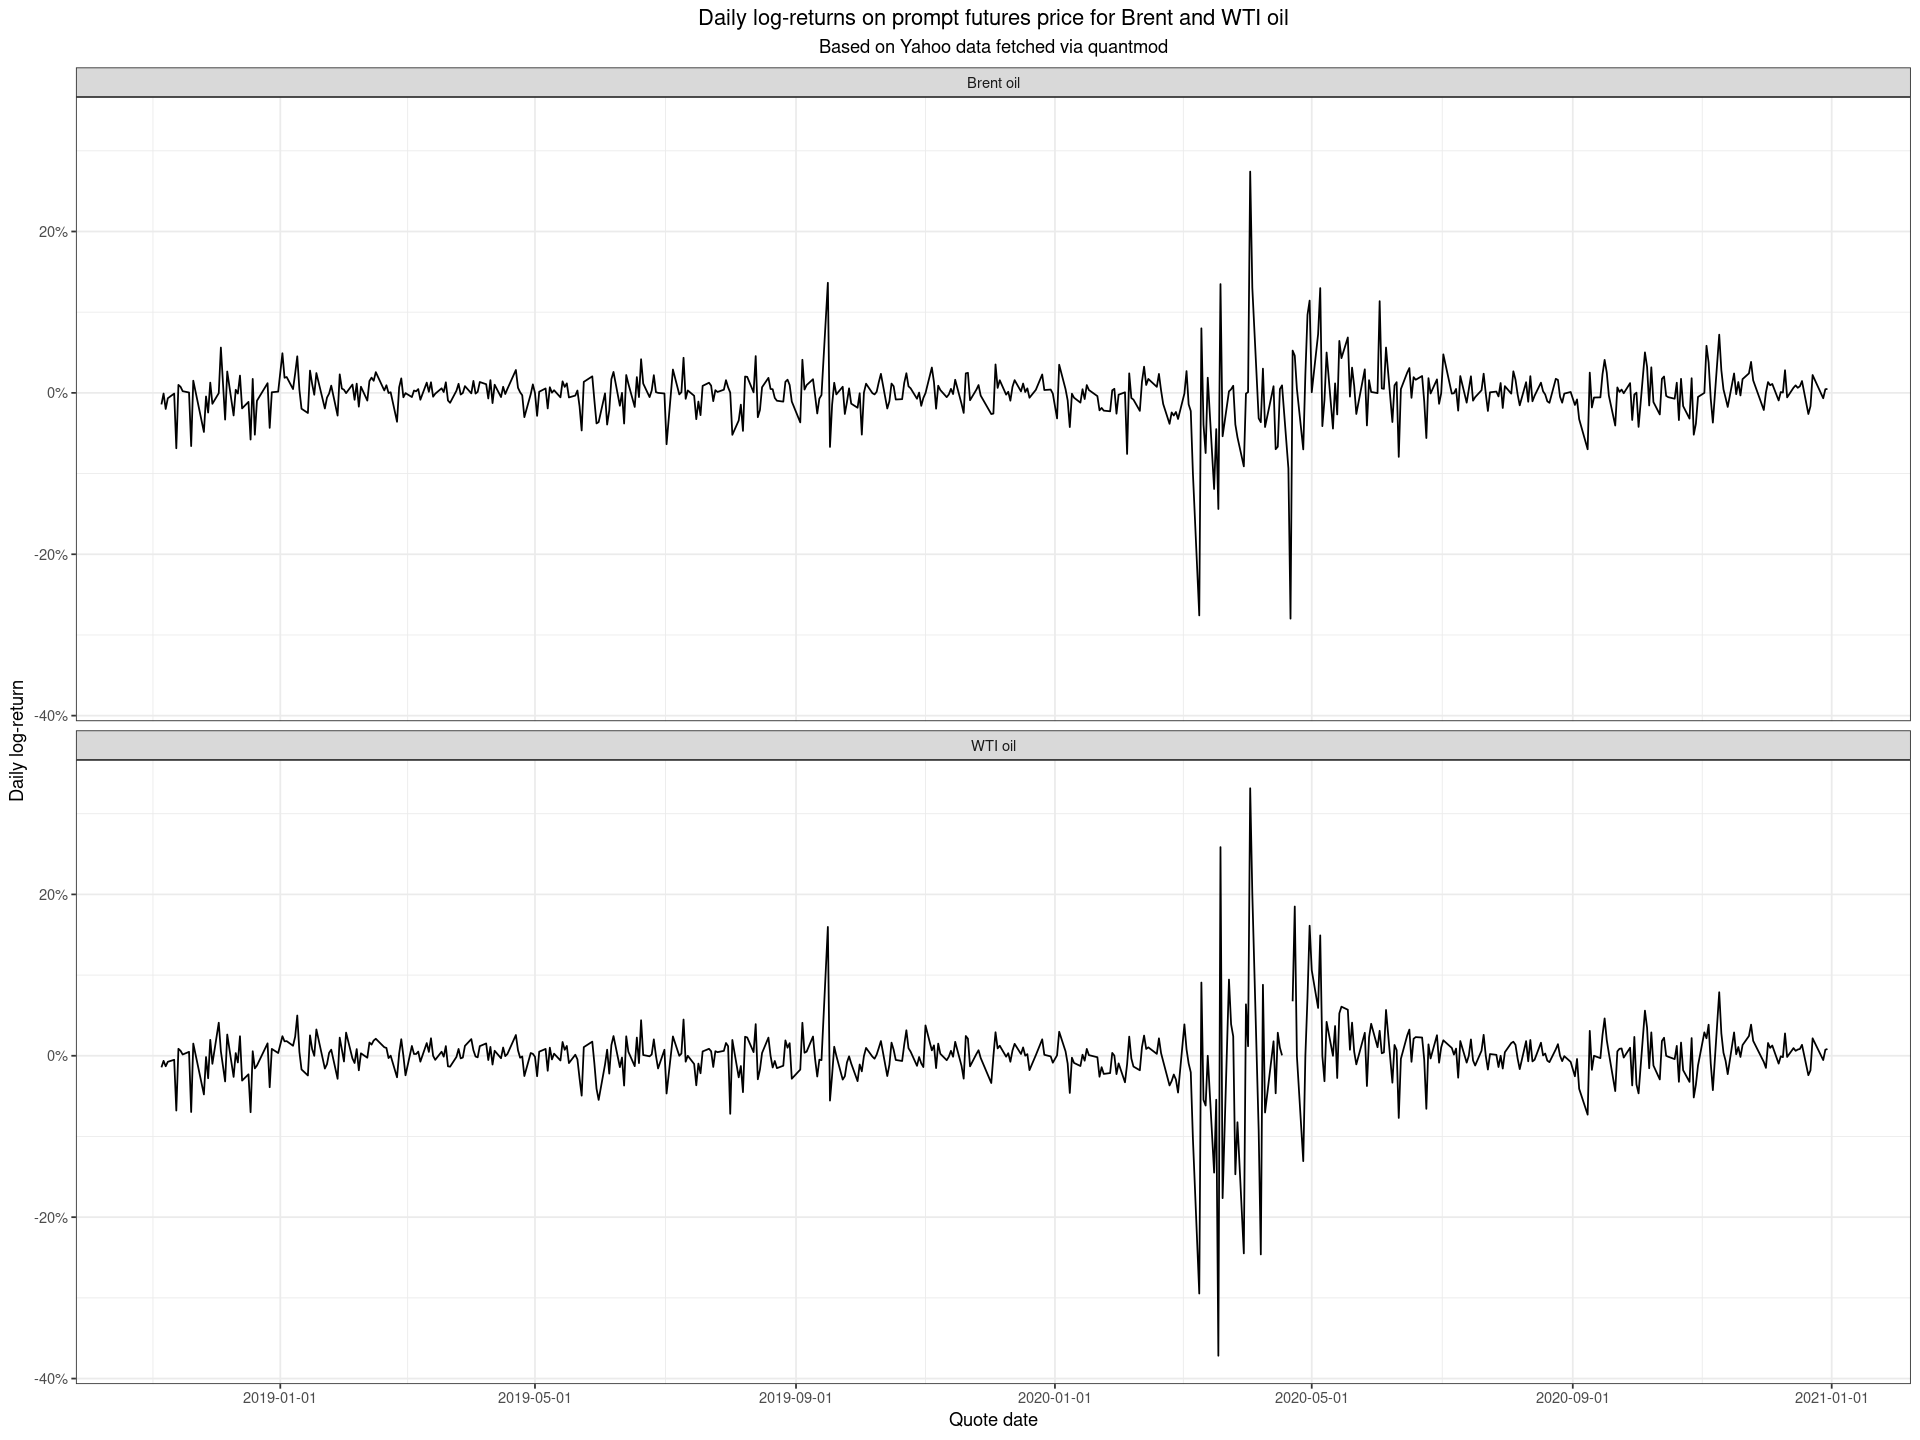

In [14]:
# 4.3. plot log-returns of both oil prices
dtTemp <- dtOil[, .(index, logret_brent, logret_wti)]
dtTemp <- data.table::melt.data.table(
  data = dtTemp, id.vars = "index", measure.vars = c("logret_brent", "logret_wti"),
  variable.name = "which_logret", value.name = "logret_value")
plotWrappedLogReturnsOil <- ggplot(data = dtTemp, mapping = aes(x = index, y = logret_value)) +
  geom_line() +
  facet_wrap(facets = .~which_logret, nrow = 2, labeller = labeller(
    which_logret = c("logret_brent" = "Brent oil", 
                     "logret_wti" = "WTI oil"))) + 
  theme_bw() +
  ylab("Daily log-return") +
  xlab("Quote date") +
  ggtitle(
    label = "Daily log-returns on prompt futures price for Brent and WTI oil",
    subtitle = "Based on Yahoo data fetched via quantmod"
  ) + 
  scale_x_date(breaks = "4 month") +
  scale_y_continuous(labels = scales::percent) +
  theme(
    plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5)
  )
plotWrappedLogReturnsOil

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


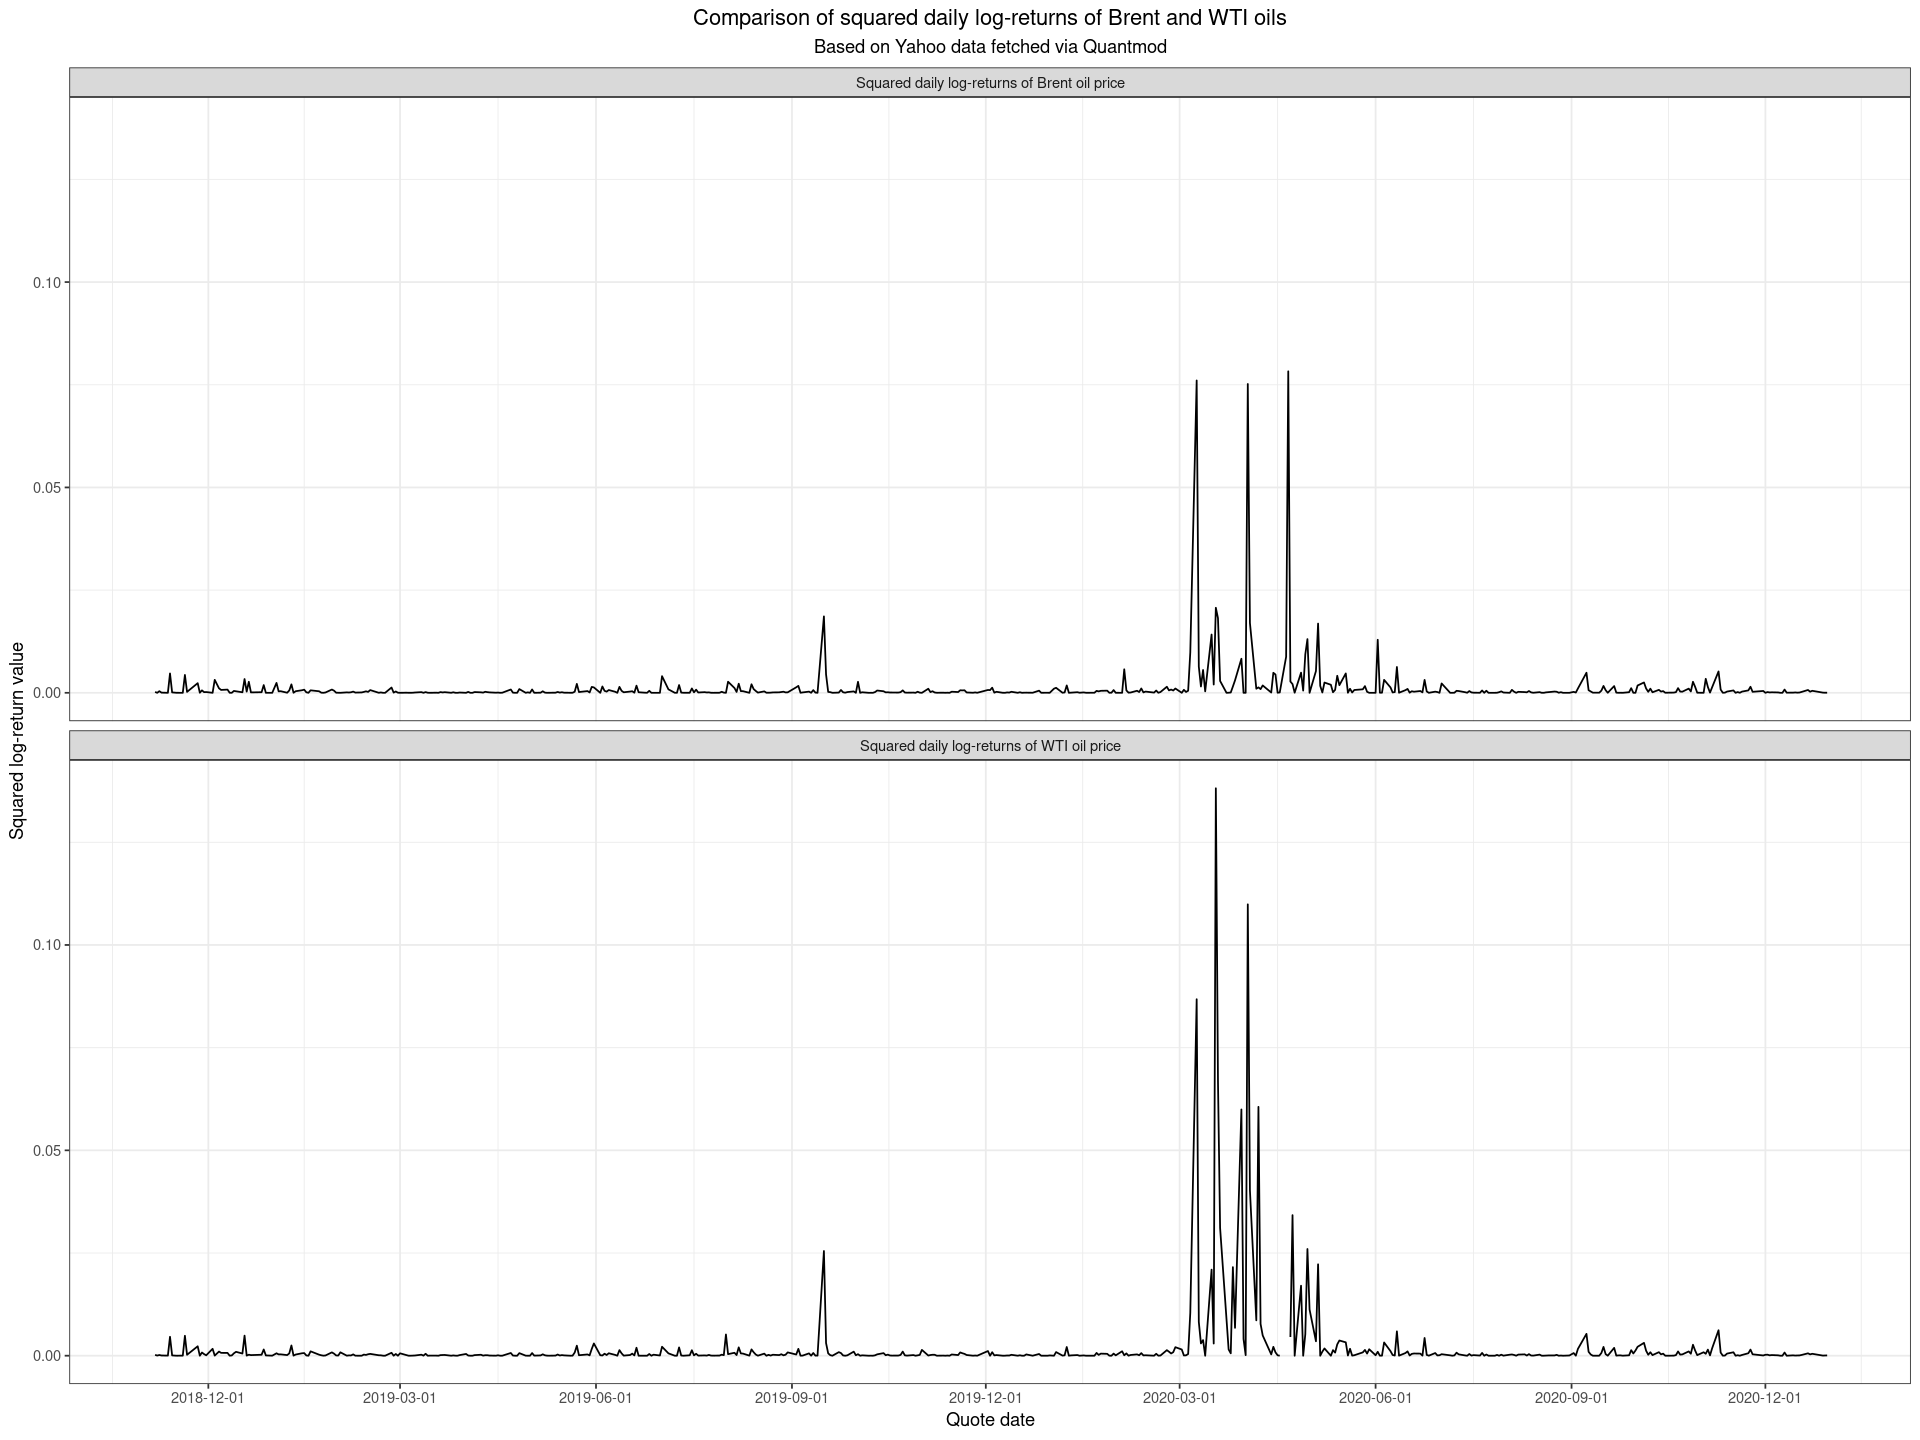

In [15]:
# 4.4. plot squared log-returns of both oil prices
dtTemp2 <- dtOil[, .(index, sq_logret_brent, sq_logret_wti)]
dtTemp2 <- data.table::melt.data.table(
  data = dtTemp2, id.vars = "index", measure.vars = c("sq_logret_brent", "sq_logret_wti"),
  variable.name = "which_oil",
  value.name = "sq_logret")
plotWrappedSquaredLogReturnsOil <- 
  ggplot(data = dtTemp2, mapping = aes(x = index, y = sq_logret)) +
  geom_line() +
  facet_wrap(. ~ which_oil, labeller = labeller(
    which_oil = c(
      "sq_logret_brent" = "Squared daily log-returns of Brent oil price",
      "sq_logret_wti" = "Squared daily log-returns of WTI oil price"
    )
  ), nrow = 2) +
  ggtitle(
    label = "Comparison of squared daily log-returns of Brent and WTI oils",
    subtitle = "Based on Yahoo data fetched via Quantmod"
  ) + theme_bw() +
  xlab("Quote date") + ylab(label = "Squared log-return value") +
  scale_x_date(breaks = "3 months") +
  theme(
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5)
  )
plotWrappedSquaredLogReturnsOil

Warning message:
“Removed 4 rows containing non-finite values (stat_bin).”


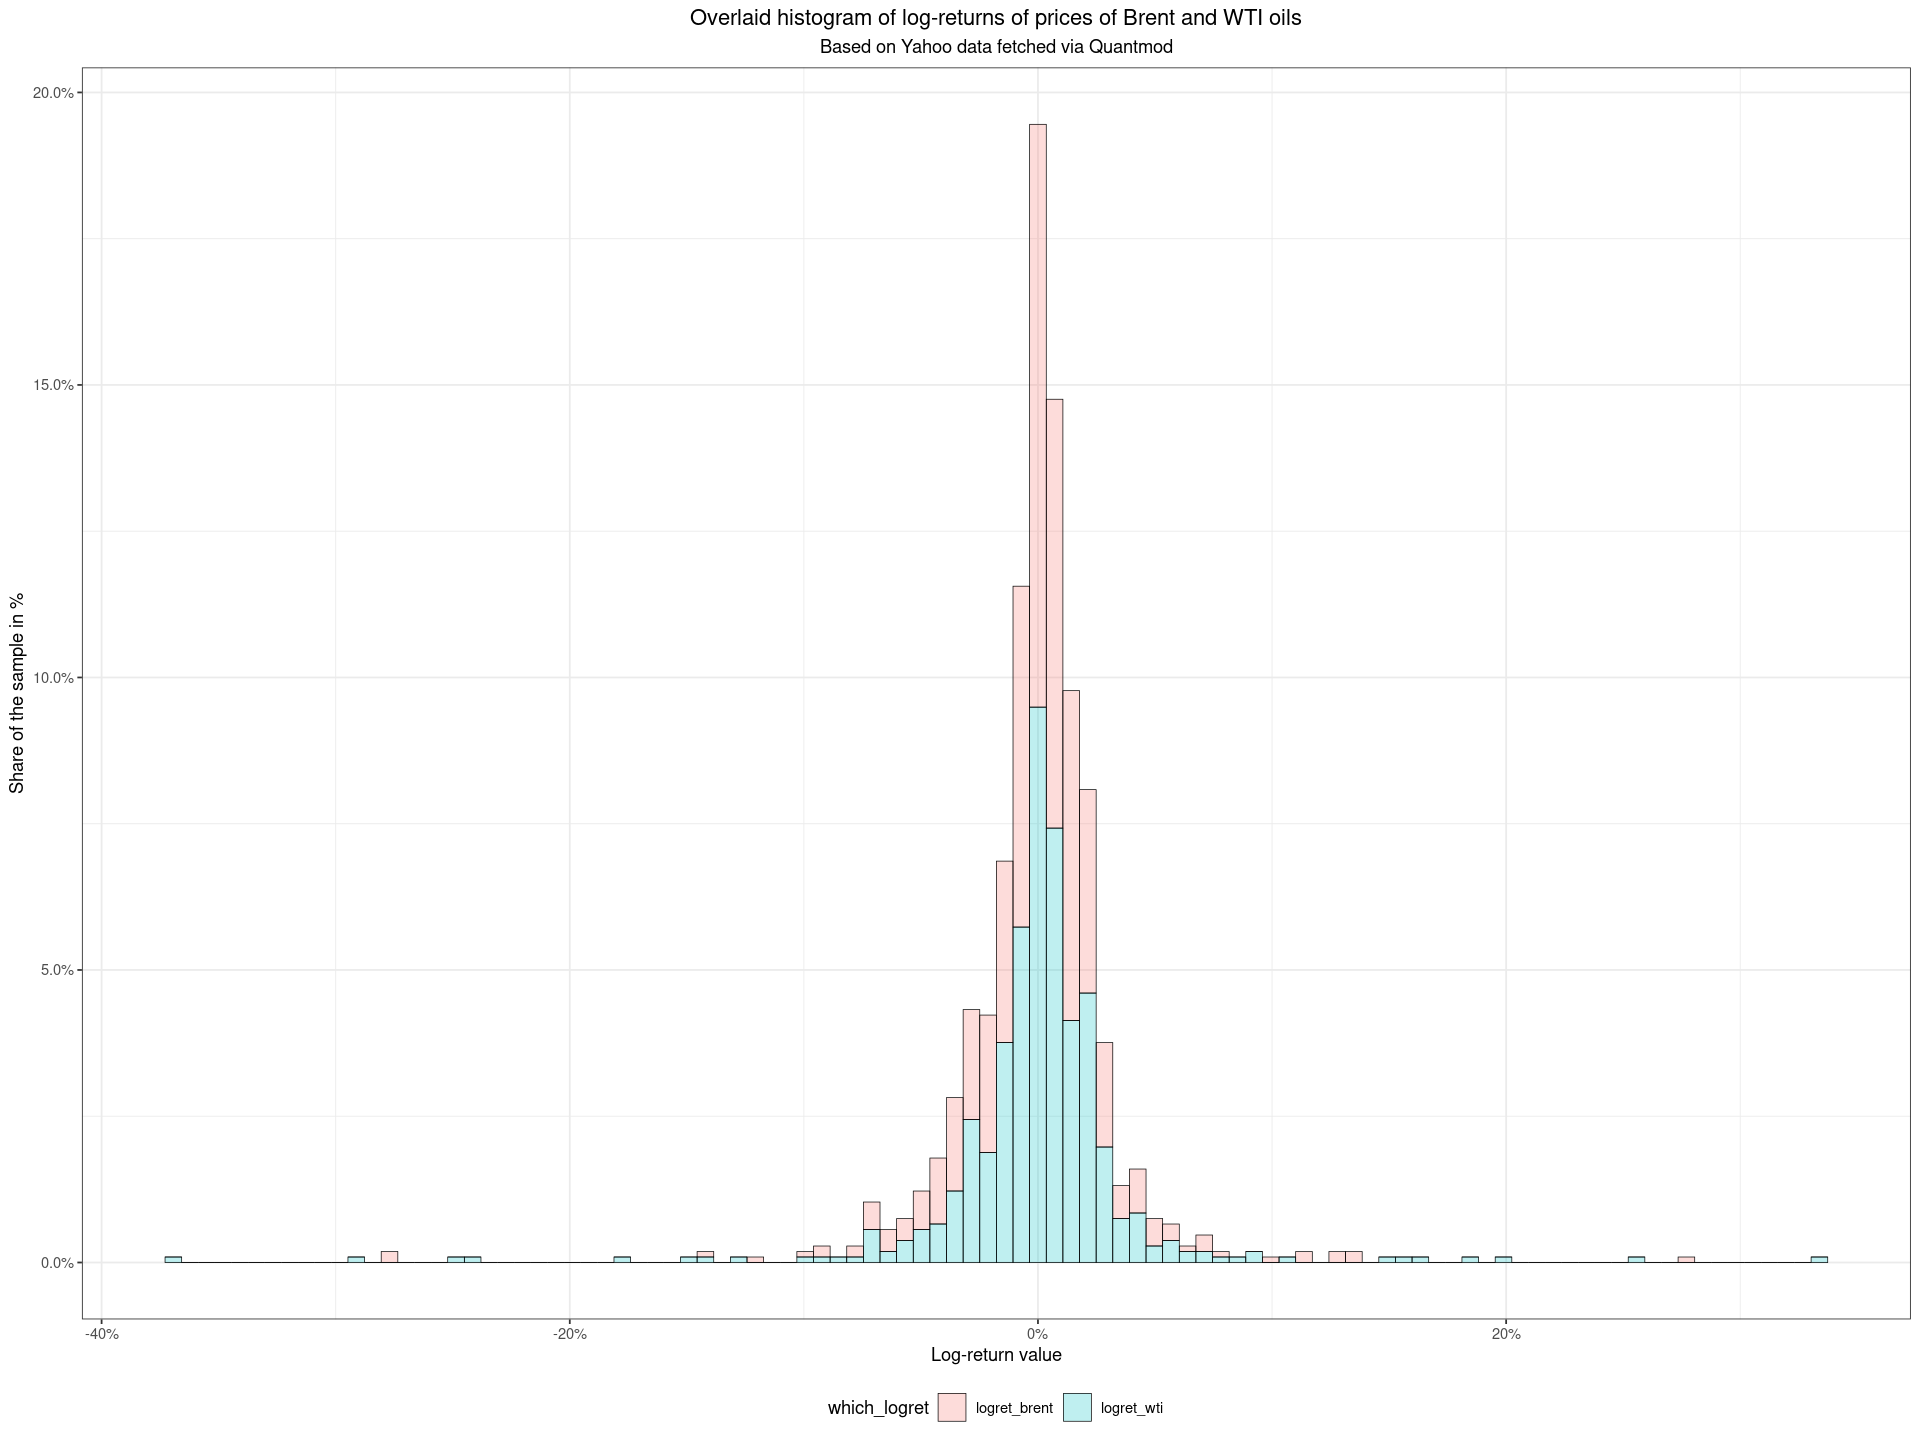

In [17]:
# 4.5. make overlaid histogram for both log-returns time series
dtHistData <- dtOil[, .(index, logret_brent, logret_wti)]
dtHistData <- data.table::melt.data.table(
  data = dtHistData, id.vars = "index", measure.vars = c("logret_brent", "logret_wti"), 
  variable.name = "which_logret", value.name = "logret_value"
)
plotHistorgam <- ggplot(data = dtHistData, mapping = aes(x = logret_value, fill = which_logret)) +
  geom_histogram(bins = 100, aes(y =..count../sum(..count..)), alpha = 0.25, color = "black", size = 0.2) +
  theme_bw() + xlab(label = "Log-return value") + 
  ylab("Share of the sample in %") +
  scale_y_continuous(labels = scales::percent) +
  scale_x_continuous(labels = scales::percent) +
  ggtitle(
    label = "Overlaid histogram of log-returns of prices of Brent and WTI oils",
    subtitle = "Based on Yahoo data fetched via Quantmod"
  ) + theme(
    plot.title = element_text(hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5),
    legend.position = "bottom"
  ) + guides(fill = guide_legend(title = "which_logret"))
plotHistorgam

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


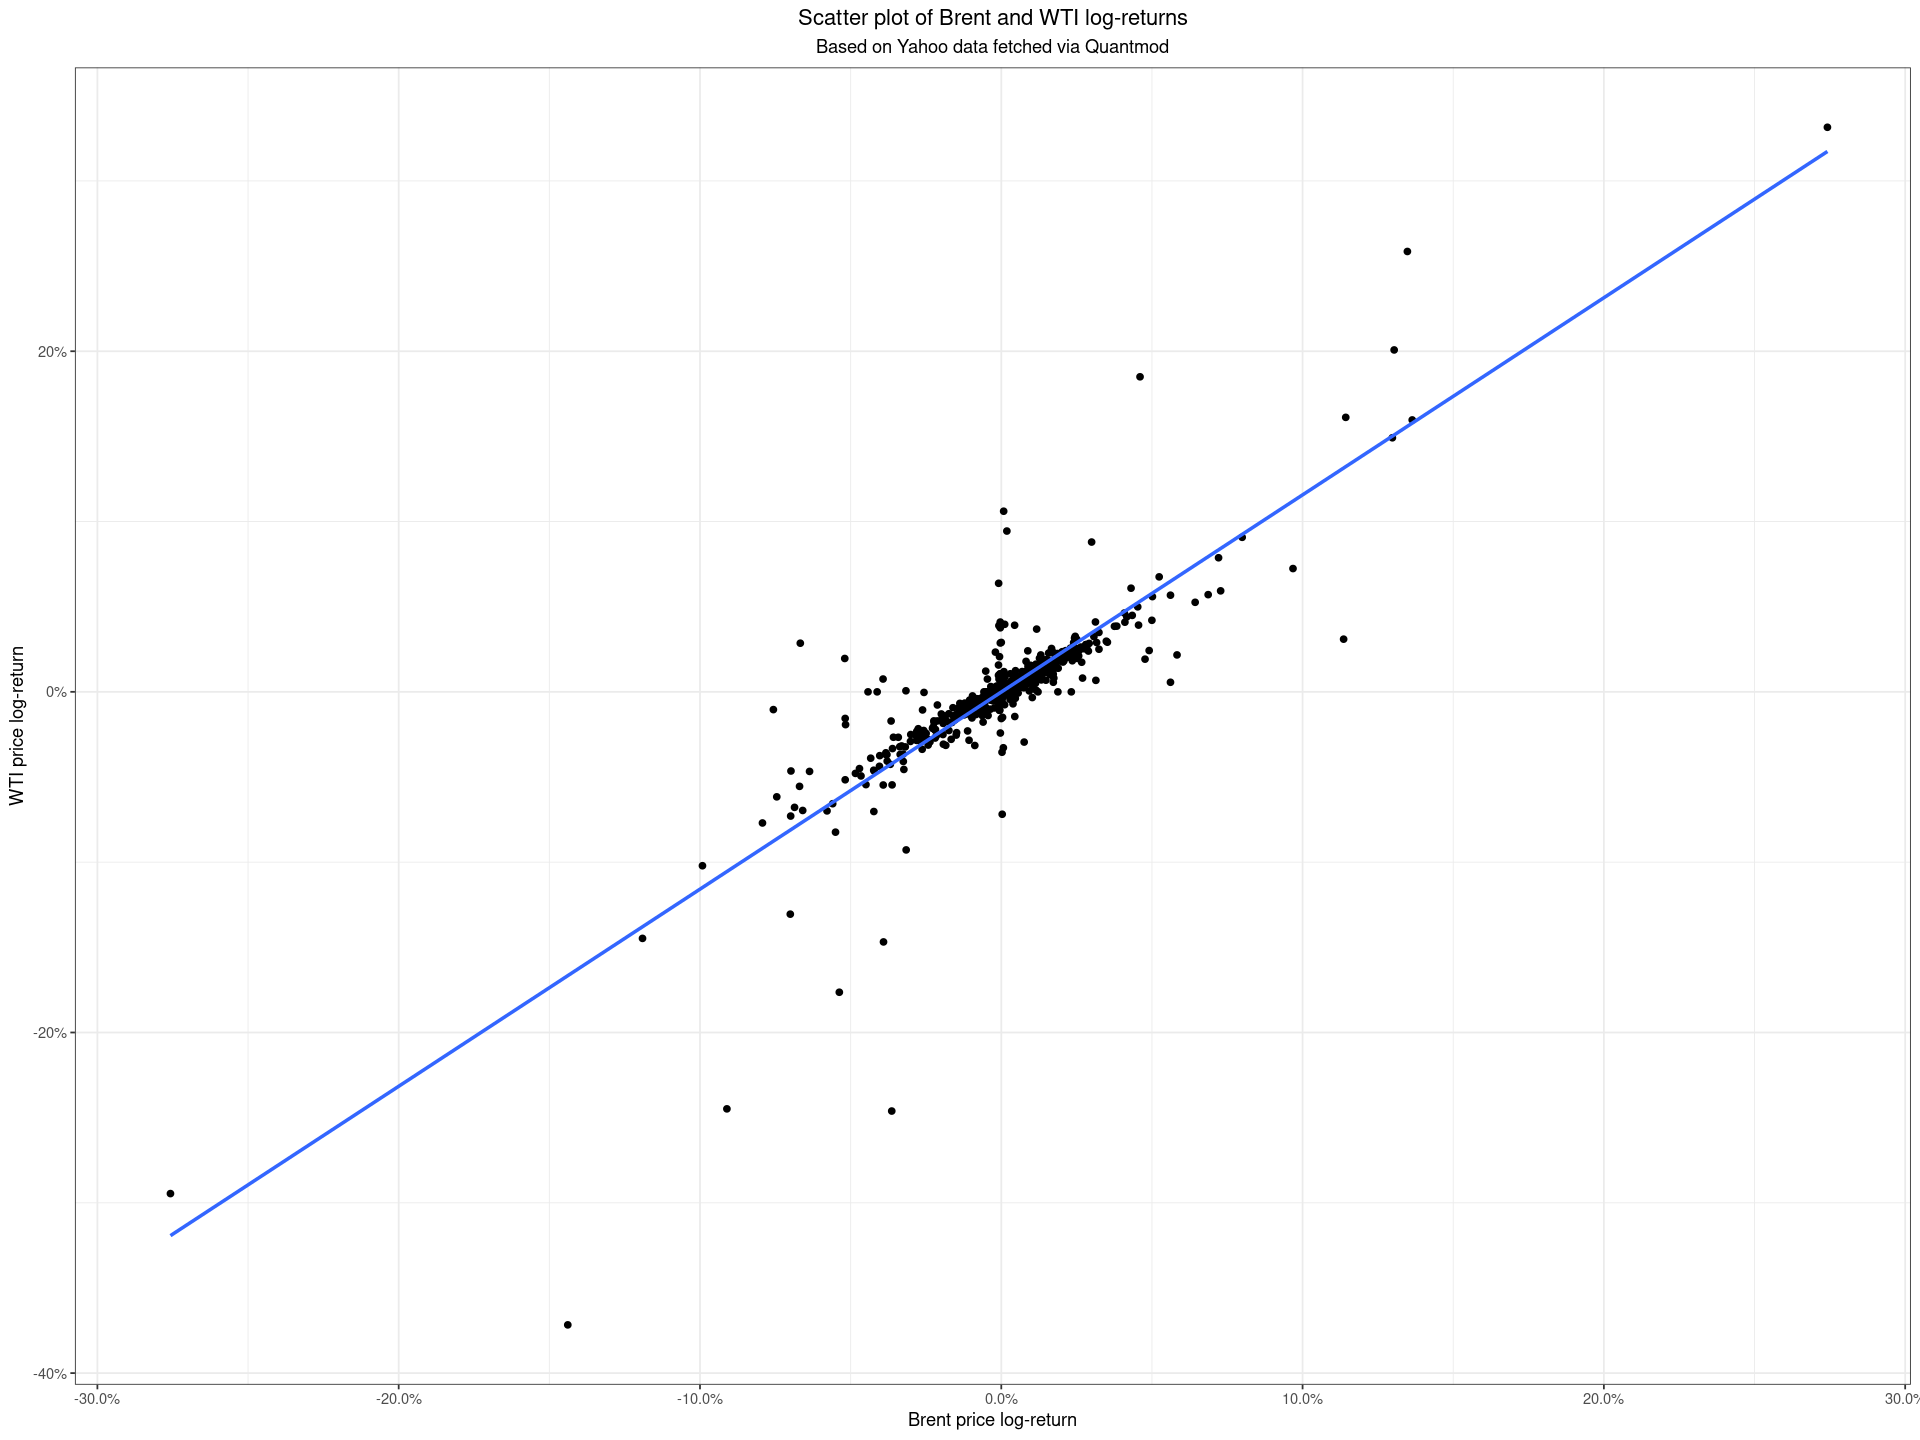

In [18]:
# 4.6. make scatter plot for the log-returns
dtScatter <- dtOil[, .(index, logret_brent, logret_wti)]
dtScatter[, which_year := as.character(paste0("Y", lubridate::year(x = index)))]
plotSingleScatter <- 
  ggplot(data = dtScatter, aes(x = logret_brent, y = logret_wti)) +
  geom_point() + theme_bw() +
  scale_x_continuous(labels = scales::percent) + scale_y_continuous(labels = scales::percent) +
  theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5)) + 
  xlab("Brent price log-return") + ylab("WTI price log-return") +
  ggtitle(
    label = "Scatter plot of Brent and WTI log-returns", 
    subtitle = "Based on Yahoo data fetched via Quantmod"
  ) + geom_smooth(se = F, method = "lm")
plotSingleScatter
